In [1]:
using QuantumRelay
using Klara
using DataFrames
using PyPlot
using ProfileView

In [2]:
function qrelay(alpha, delta, name)
    n = 6
    chi = fill(sqrt(0.06), n)
    phi = im * tanh(chi)
    omega = 1.0 / prod(cosh(chi))^2
    syms, op = qrelay_op(n, phi, alpha, delta)
    op_a, op_ab, mat, coef = op_mat(op)

    op_q2 = [syms.apH[1], syms.apV[1], syms.bpH[end], syms.bpV[end]]
    op_q1 = [syms.apH[2:end]..., syms.apV[2:end]..., syms.bpH[1:end-1]..., syms.bpV[1:end-1]...]
    mask_q1 = [op in op_q1 for op in op_a];
    mask_q2 = [op in op_q2 for op in op_a];
    qq = [x in syms.apH || x in syms.bpV ? 1 : 0 for x in op_a]
    
    pdet0 = pdet_maker(0.04, 1e-5)
    qrs = QRelaySampler(mat, coef, omega, pdet0)

    targetcache = Dict{Vector{Int}, Float64}()
    function plogtarget(na::Vector{Int})
        get!(targetcache, na) do
            log(qrs.prob(qq, na, mask_q1) * qrs.prob(na))
        end
    end
#     plogtarget(na::Vector{Int}) = log(qrs.prob(qq, na, mask_q1) * qrs.prob(na))
    p = BasicDiscMuvParameter(:p, logtarget=plogtarget)
    model = likelihood_model([p], isindexed=false)
    sampler = MH(qrs.psetproposal, symmetric=false)
    mcrange = BasicMCRange(nsteps=2^20 + 2^10, burnin=2^10, thinning=2^5)
    v0 = Dict(:p=>zeros(qq))
    outopts = Dict{Symbol, Any}(
        :monitor=>[:value, :logtarget],
        :diagnostics=>[:accept],
        :destination=>:iostream,
        :filepath=>"$dataname/"*name
    )
    job = BasicMCJob(model, sampler, mcrange, v0, outopts=outopts)

    funcQ(v) = qrs.prob(qq, v, mask_q2)
    
    return qrs, job, funcQ
end

qrelay (generic function with 1 method)

In [3]:
dataname="data3"
results = []
for i = 0:12
    beta = i*pi/12
    name = string(i)
    mkpath("$dataname/$name")
    qrs, job, funcQ = qrelay(pi/4, beta, name)
    println("beta:", beta)
#     @profile run(job)
    run(job)
    chain = output(job)
    push!(results, (qrs, chain, funcQ))
end

beta:0.0
beta:0.2617993877991494
beta:0.5235987755982988
beta:0.7853981633974483
beta:1.0471975511965976
beta:1.3089969389957472


LoadError: InterruptException:

In [ ]:
ProfileView.view()

In [4]:
binning_level = 10
nresult = length(results)
Qs = zeros(nresult)
err = zeros(binning_level, nresult)
accept = zeros(nresult)

for (j, (qrs, chain, funcQ)) in enumerate(results[1:5])
    Qarr = zeros(chain.n)
    values = Array(readtable("$dataname/$(j-1)/value.csv", header=false, eltypes=fill(Int, 24)))
    acceptarr = Array(readtable("$dataname/$(j-1)/diagnosticvalues.csv", header=false, eltypes=[Bool]))
    accept[j] = countnz(acceptarr)/chain.n
    for i in 1:chain.n
        Qarr[i] = funcQ(values[i,:])
    end
    Q = mean(Qarr)
    Qs[j] = Q
    Qarri = Qarr
    for i=1:binning_level
        Qarri = bin2(Qarri)
        err[i, j] = sqrt(var(Qarri)/length(Qarri))
    end
end

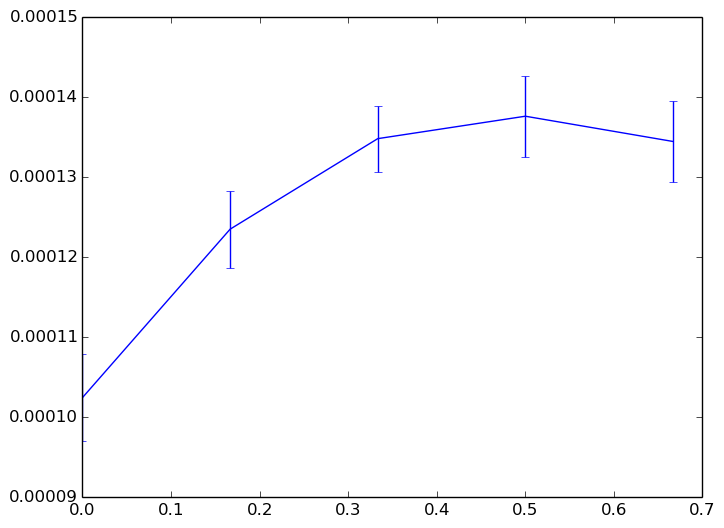

(PyObject <matplotlib.lines.Line2D object at 0x7f45bcdd3ad0>,(PyObject <matplotlib.lines.Line2D object at 0x7f45bcdd3650>,PyObject <matplotlib.lines.Line2D object at 0x7f45bcdd3710>),(PyObject <matplotlib.collections.LineCollection object at 0x7f45bcdd3190>,))

In [5]:
errorbar(linspace(0, 2, 13)[1:5], Qs[1:5], yerr=err[end, 1:5])

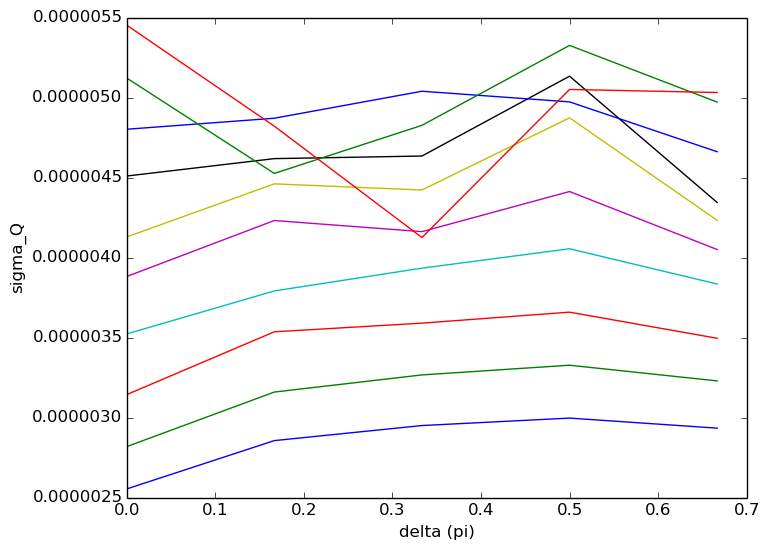

PyObject <matplotlib.text.Text object at 0x7f45bca81790>

In [8]:
x = linspace(0,2,13); y = err'
for i=1:10
    plot(x[1:5], y[1:5, i], label="binning level="*string(i))
end
xlabel("delta (pi)")
ylabel("sigma_Q")
# legend()

In [ ]:
binning_level = 5
nresult = length(results)
Qs = zeros(nresult)
err = zeros(binning_level, nresult)

for (j, (qrs, chain, funcQ)) in enumerate(results)
    Qarr = zeros(chain.n)
    values = Array(readtable("$dataname/$(j-1)/value.csv", header=false, eltypes=fill(Int, 24)))
    for i in 1:chain.n
        Qarr[i] = funcQ(values[i,:])
    end
    Q = mean(Qarr)
    Qs[j] = Q
    Qarri = Qarr
    for i=1:binning_level
        Qarri = bin2(Qarri)
        err[i, j] = sqrt(var(Qarri)/length(Qarri))
    end
end

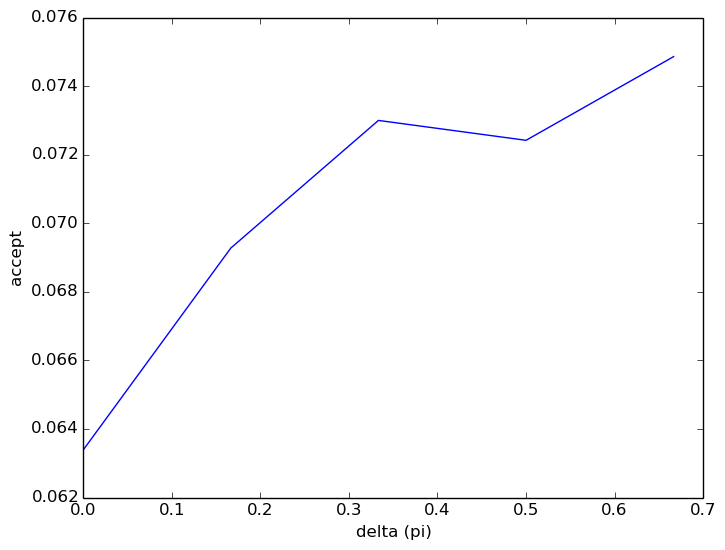

PyObject <matplotlib.text.Text object at 0x7f45bca8bc50>

In [10]:
x = linspace(0,2,13)
plot(x[1:5], accept[1:5])
xlabel("delta (pi)")
ylabel("accept")

In [ ]:
tmp=readtable("data2/0/value.csv", header=false, eltypes=fill(Int, 24))

In [ ]:
fill(Bool, 3)

In [ ]:
length(tmp[:,1])